# Appstore games: Project by Humberto Mundo

### Today we will explore the appstore games dataset from kaggle: 
https://www.kaggle.com/tristan581/17k-apple-app-store-strategy-games?select=appstore_games.csv

### We will clean the data, provide visualizations, answer some questions regarding the results we found and finally we will build a ML model. 
### Tasks:
#### 1. Answer specific questions such as: 

* In-app purchase games vs paid games vs free to play
* What genre and subgenres are the most popular?
* Which developers rack the highest/lowest average ratings?
* What are the most common words used in app descriptions?
* Change in Price, Size, and User rating count throughout the years.
* Top 5 apps with the perfect rating and highest rating count.
* What variable seems to have the most effect on a high rating?

#### 2. Build a model that predicts the rating of a game

### Table of Contents:
1. [Packages and data preparation](#1.-Packages-and-data-preparation)
2. [Quick glance at data](#2.-Quick-glance-at-data)
3. [Clean data pt.1](#3.-Clean-data-pt.1)
4. [Clean data pt.2](#4.-Clean-data-pt.2)
5. [Pre-EDA](#5.-Pre-EDA)
6. [EDA](#6.-EDA)
7. [Model preparation](#7.-Model-preparation)
8. [Model validation](#8.-Model-validation)
9. [Final model build](#9.-Final-model-build)

## 1. Packages and data preparation

In [ ]:
# data analysis
import pandas as pd
import numpy as np
import random as rnd
import math
from scipy import stats
from scipy.stats import norm, skew, mode
from scipy.special import boxcox1p

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
%matplotlib inline

# machine learning
from joblib import parallel_backend
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import precision_score,f1_score

import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool

import warnings
warnings.filterwarnings('ignore')

In [3]:
games = pd.read_csv('appstore_games.csv')
games.head(3)

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017


In [4]:
#save icon URl
icons = games['Icon URL']
descriptions = games['Description']

## 2. Quick glance at data

##### Dataset info

In [5]:
print("Number of rows:", games.shape[0])
print("Number of columns:", games.shape[1])
print("----------------------------------------------------")
print(games.info())

Number of rows: 17007
Number of columns: 18
----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   URL                           17007 non-null  object 
 1   ID                            17007 non-null  int64  
 2   Name                          17007 non-null  object 
 3   Subtitle                      5261 non-null   object 
 4   Icon URL                      17007 non-null  object 
 5   Average User Rating           7561 non-null   float64
 6   User Rating Count             7561 non-null   float64
 7   Price                         16983 non-null  float64
 8   In-app Purchases              7683 non-null   object 
 9   Description                   17007 non-null  object 
 10  Developer                     17007 non-null  object 
 11  Age Rating            

In [6]:
games.describe()

,ID,Average User Rating,User Rating Count,Price,Size
count,1.700700e+04,7561.000000,7.561000e+03,16983.000000,1.700600e+04
mean,1.059614e+09,4.060905,3.306531e+03,0.813419,1.157064e+08
std,2.999676e+08,0.751428,4.232256e+04,7.835732,2.036477e+08
min,2.849214e+08,1.000000,5.000000e+00,0.000000,5.132800e+04
25%,8.996543e+08,3.500000,1.200000e+01,0.000000,2.295014e+07
50%,1.112286e+09,4.500000,4.600000e+01,0.000000,5.676895e+07
75%,1.286983e+09,4.500000,3.090000e+02,0.000000,1.330271e+08
max,1.475077e+09,5.000000,3.032734e+06,179.990000,4.005591e+09


##### Missing values

In [7]:
total = games.isnull().sum().sort_values(ascending=False)
percent = (total/games.isnull().count()).sort_values(ascending=False)*100
dtype = games.dtypes
na_table = pd.concat([total,percent,dtype], axis=1, keys=['Total', '%', 'Dtype'])
na_table

,Total,%,Dtype
Subtitle,11746,69.065679,object
Average User Rating,9446,55.541836,float64
User Rating Count,9446,55.541836,float64
In-app Purchases,9324,54.824484,object
Languages,60,0.352796,object
Price,24,0.141118,float64
Size,1,0.005880,float64
URL,0,0.000000,object
Original Release Date,0,0.000000,object
Genres,0,0.000000,object


#### The columns that contain Null values: Subtitle, Average User Rating, User Rating Count, In-app Purchases, Languages, Price, Size	

## 3. Clean data pt.1

##### Drop useless columns

In [8]:
games = games.drop(['ID','URL','Subtitle','Icon URL','Description'], axis = 1)

In [9]:
total = games.isnull().sum().sort_values(ascending=False)
percent = (total/games.isnull().count()).sort_values(ascending=False)*100
dtype = games.dtypes
na_table = pd.concat([total,percent,dtype], axis=1, keys=['Total', '%', 'Dtype'])
na_table

,Total,%,Dtype
Average User Rating,9446,55.541836,float64
User Rating Count,9446,55.541836,float64
In-app Purchases,9324,54.824484,object
Languages,60,0.352796,object
Price,24,0.141118,float64
Size,1,0.005880,float64
Name,0,0.000000,object
Developer,0,0.000000,object
Age Rating,0,0.000000,object
Primary Genre,0,0.000000,object


#### The remaining columns that contain Null values:  Average User Rating, User Rating Count,	In-app Purchases, Languages, Price, Size.
#### As we can see the missing values for both rating columns go hand in hand.
Let's locate the one missing size

In [10]:
games[games['Size'].isnull()]
#games.iloc[16782]

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
16782,Idle Mars Colonization,NaN,NaN,NaN,"0.99, 1.99, 4.99",mai phuong bui,4+,EN,NaN,Games,"Games, Strategy, Simulation",18/08/2019,18/08/2019


#### Fix NA columns

In [11]:
def na_median(column):
    return column.fillna(column.median())

In [12]:
games['Size']=games['Size'].transform(na_median)

In [13]:
games['Price']=games['Price'].transform(na_median)

In [14]:
games['Average User Rating']=games['Average User Rating'].transform(na_median)

In [15]:
games['User Rating Count']=games['User Rating Count'].transform(na_median)

In [16]:
total = games.isnull().sum().sort_values(ascending=False)
percent = (total/games.isnull().count()).sort_values(ascending=False)*100
dtype = games.dtypes
na_table = pd.concat([total,percent,dtype], axis=1, keys=['Total', '%', 'Dtype'])
na_table.head()

,Total,%,Dtype
In-app Purchases,9324,54.824484,object
Languages,60,0.352796,object
Name,0,0.000000,object
Average User Rating,0,0.000000,float64
User Rating Count,0,0.000000,float64


2 more columns need to be filled, due to lack of information we will fill all missing in-app purchases with 0. Then fill the remaining missing languages to english.

In [17]:
games['Languages'] = games['Languages'].fillna("EN", axis=0)
games['In-app Purchases'] = games['In-app Purchases'].fillna(0, axis=0)

In [18]:
total = games.isnull().sum().sort_values(ascending=False)
percent = (total/games.isnull().count()).sort_values(ascending=False)*100
dtype = games.dtypes
na_table = pd.concat([total,percent,dtype], axis=1, keys=['Total', '%', 'Dtype'])
na_table.head()

,Total,%,Dtype
Name,0,0.0,object
Average User Rating,0,0.0,float64
User Rating Count,0,0.0,float64
Price,0,0.0,float64
In-app Purchases,0,0.0,object


##### We have no more NULL values, let's see what else we need to fix.

In [19]:
games.head(2)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,Sudoku,4.0,3553.0,2.99,0,Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,Reversi,3.5,284.0,1.99,0,Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018


## 4. Clean data pt.2 

#### Now that the data is cleansed from Null values, we still need to tweak a few more things.
* converting the size to megabytes
* fixing the dates
* fix age rating
* fix languages
* fix genres
* fix in-app purchases

In [20]:
games['Size'] = round(games['Size']/1000000, 2)
games.head(2)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,Sudoku,4.0,3553.0,2.99,0,Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15.85,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,Reversi,3.5,284.0,1.99,0,Kiss The Machine,4+,EN,12.33,Games,"Games, Strategy, Board",11/07/2008,17/05/2018


In [21]:
games['Original Release Date'] = games['Original Release Date'].str.extract(r'\b(\w+)$')
games['Current Version Release Date'] = games['Current Version Release Date'].str.extract(r'\b(\w+)$')
games.head(3)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,Sudoku,4.0,3553.0,2.99,0,Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15.85,Games,"Games, Strategy, Puzzle",2008,2017
1,Reversi,3.5,284.0,1.99,0,Kiss The Machine,4+,EN,12.33,Games,"Games, Strategy, Board",2008,2018
2,Morocco,3.0,8376.0,0.00,0,Bayou Games,4+,EN,0.67,Games,"Games, Board, Strategy",2008,2017


In [22]:
games['Age Rating'] = games['Age Rating'].str.replace('+','').astype(int)
games.head(2)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,Sudoku,4.0,3553.0,2.99,0,Mighty Mighty Good Games,4,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15.85,Games,"Games, Strategy, Puzzle",2008,2017
1,Reversi,3.5,284.0,1.99,0,Kiss The Machine,4,EN,12.33,Games,"Games, Strategy, Board",2008,2018


In [23]:
games['Languages'] = games['Languages'].apply(lambda x: len(x.split(',')))
games.head(2)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,Sudoku,4.0,3553.0,2.99,0,Mighty Mighty Good Games,4,17,15.85,Games,"Games, Strategy, Puzzle",2008,2017
1,Reversi,3.5,284.0,1.99,0,Kiss The Machine,4,1,12.33,Games,"Games, Strategy, Board",2008,2018


In [24]:
#games['Primary Genre'].unique()
games['Genres'].unique()

array(['Games, Strategy, Puzzle', 'Games, Strategy, Board',
       'Games, Board, Strategy', ..., 'Games, Strategy, Sports, Music',
       'Social Networking, Games, Strategy, Casual',
       'Sports, Racing, Games, Strategy'], dtype=object)

In [25]:
Primary_Genre = []
Secondary_Genre = []
for x in games['Genres']:
    Primary_Genre.append(x.split(',')[0])
    Secondary_Genre.append(x.split(',')[1])
    
games['Primary Genre'] = Primary_Genre
games['Genres'] = Secondary_Genre

In [26]:
games.head(2)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,Sudoku,4.0,3553.0,2.99,0,Mighty Mighty Good Games,4,17,15.85,Games,Strategy,2008,2017
1,Reversi,3.5,284.0,1.99,0,Kiss The Machine,4,1,12.33,Games,Strategy,2008,2018


In [27]:
games.rename(columns={"Genres": "Secondary Genre"}, inplace = True)

In [28]:
games['In-app Purchases'] = games['In-app Purchases'].apply(lambda x:1 if x!= 0 else 0)

In [29]:
games.tail(2)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Primary Genre,Secondary Genre,Original Release Date,Current Version Release Date
17005,FaTaLL,4.5,46.0,0.0,1,Tayrem Games,4,1,196.75,Games,Strategy,2019,2019
17006,The Three Kingdoms :Bomb,4.5,46.0,0.0,0,ming bo tang,4,2,22.95,Games,Strategy,2019,2019


In [30]:
games['In-app Purchases'].unique()

array([0, 1], dtype=int64)

## 5. Pre-EDA
We are all set, the data is now clean and we can take a look at the relationships between variables etc. before we begin our EDA and modeling.

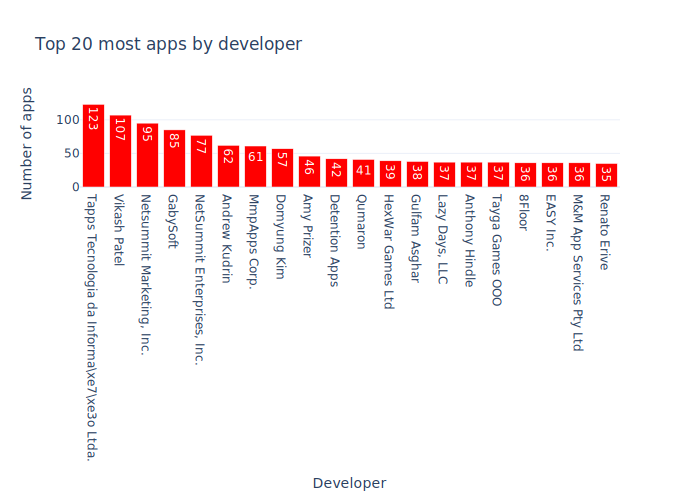

In [37]:
a = []
b = []
for x,y in games['Developer'].value_counts()[:20].iteritems():
    a.append(x)
    b.append(y)
    
    
fig = go.Figure([go.Bar(x=a ,y=b, text=b, marker_color='red')])
fig.update_layout(template='plotly_white',title_text='Top 20 most apps by developer')
fig.update_yaxes(title_text='Number of apps')
fig.update_xaxes(title_text='Developer',tickfont_size=12)
fig.show(renderer="svg")

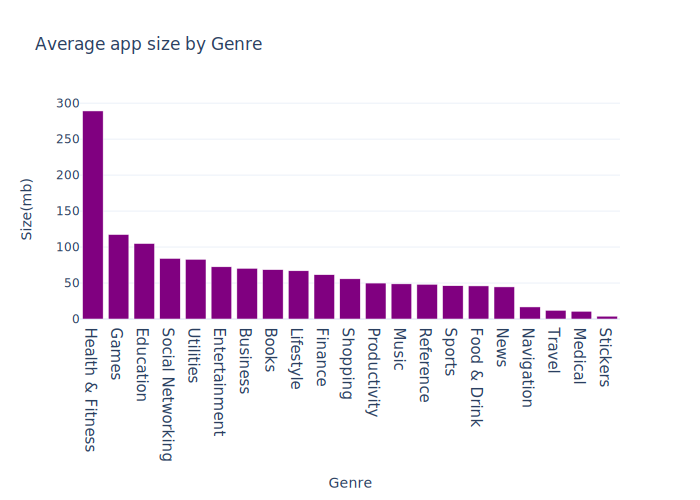

In [36]:
a = []
b = []
for x,y in games.groupby('Primary Genre')[['Size']].mean().sort_values(by = ['Size'], ascending = False).iteritems():
    for w,z in y.iteritems():
        a.append(w)
        b.append(z)
        
        
fig = go.Figure([go.Bar(x =a ,y = b, marker_color='purple')])
fig.update_layout(template='plotly_white',title_text='Average app size by Genre')
fig.update_yaxes(title_text='Size(mb)')
fig.update_xaxes(title_text='Genre',tickfont_size=15)
fig.show(renderer="svg")        

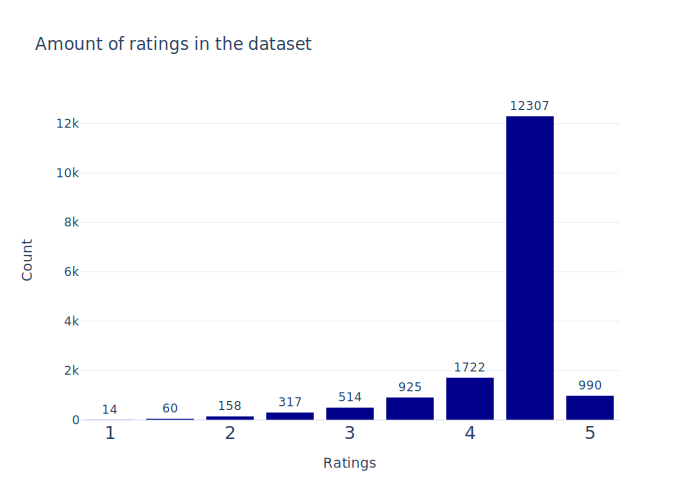

In [38]:
a = []
b = []
for x,y in games['Average User Rating'].value_counts().iteritems():
    a.append(x)
    b.append(y)
    
     
fig = go.Figure([go.Bar(x=a, y=b , text=b, textposition='outside', marker_color='darkblue')])
fig.update_layout(template='plotly_white',title_text='Amount of ratings in the dataset')
fig.update_yaxes(title_text='Count')
fig.update_xaxes(title_text='Ratings',tickfont_size=18)
fig.show(renderer="svg")    

##### Correlation heatmap

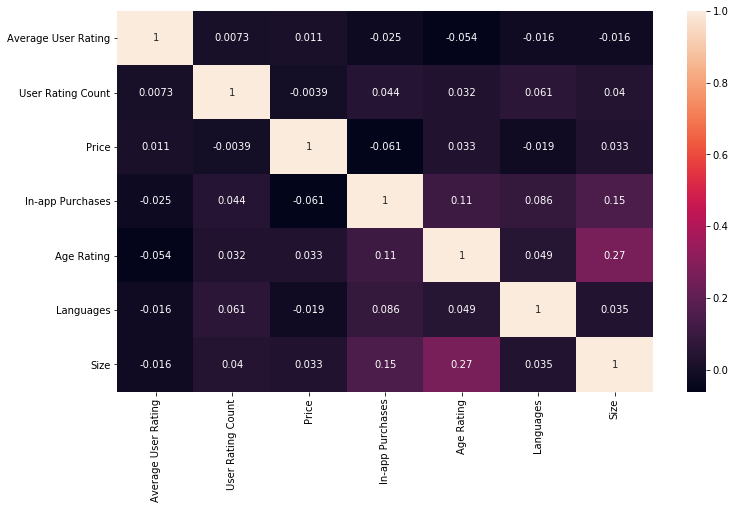

In [39]:
f,ax= plt.subplots(figsize=(12,7))
g = sns.heatmap(games.corr(),annot= True)
bottom, top = g.get_ylim()
g.set_ylim(bottom+.5, top-.5)
plt.show()

Interesting find, as the dates progress so did most the average user ratings:

In [40]:
games[['Original Release Date','Average User Rating']].groupby('Original Release Date', as_index=False).mean()

,Original Release Date,Average User Rating
0,2008,3.361702
1,2009,3.329545
2,2010,3.606498
3,2011,3.967347
4,2012,4.107682
5,2013,4.142980
6,2014,4.263074
7,2015,4.338222
8,2016,4.367882
9,2017,4.399042


Before we begin we need to add another column to our games dataframe.

In [41]:
temp1= [x for x in zip(games['Price'], games['In-app Purchases'])]
temp2 = []
for x,y in temp1:
    if x == 0.0 and y == 0:
        temp2.append(1)
    else:
        temp2.append(0)
        

In [42]:
games['FreeToPlay'] = temp2
games.head()

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Primary Genre,Secondary Genre,Original Release Date,Current Version Release Date,FreeToPlay
0,Sudoku,4.0,3553.0,2.99,0,Mighty Mighty Good Games,4,17,15.85,Games,Strategy,2008,2017,0
1,Reversi,3.5,284.0,1.99,0,Kiss The Machine,4,1,12.33,Games,Strategy,2008,2018,0
2,Morocco,3.0,8376.0,0.00,0,Bayou Games,4,1,0.67,Games,Board,2008,2017,1
3,Sudoku (Free),3.5,190394.0,0.00,0,Mighty Mighty Good Games,4,17,21.55,Games,Strategy,2008,2017,1
4,Senet Deluxe,3.5,28.0,2.99,0,RoGame Software,4,15,34.69,Games,Strategy,2008,2018,0


## 6. EDA

In [43]:
#games.columns.values
variables = ['Name', 'Average User Rating', 'User Rating Count', 'Price',
       'In-app Purchases', 'Developer', 'Age Rating', 'Languages', 'Size',
       'Primary Genre', 'Secondary Genre', 'Original Release Date',
       'Current Version Release Date']

numerical = games.select_dtypes(exclude=['object']).columns
categorical = games.select_dtypes(include=['object']).columns

Y = games['Average User Rating']

In [44]:
#in app purchase average
b = []
for x,y in games.groupby('In-app Purchases')[['Average User Rating']].mean().sort_values(by = ['Average User Rating'], ascending = False).iteritems():
    for w,z in y.iteritems():
        b.append(z)
        
        
temp = []
for x in games['Price']:
    if x == 0.0:
        temp.append(0)
    else:
        temp.append(1) 
        
#paid average              
d = []
for x,y in games.groupby(temp)[['Average User Rating']].mean().sort_values(by = ['Average User Rating'], ascending = False).iteritems():
    for w,z in y.iteritems():
        d.append(z) 

#freetoplay average
f = []
for x,y in games.groupby('FreeToPlay')[['Average User Rating']].mean().sort_values(by = ['Average User Rating'], ascending = False).iteritems():
    for w,z in y.iteritems():
        f.append(z)

### In-app purchase games vs paid games vs free to play

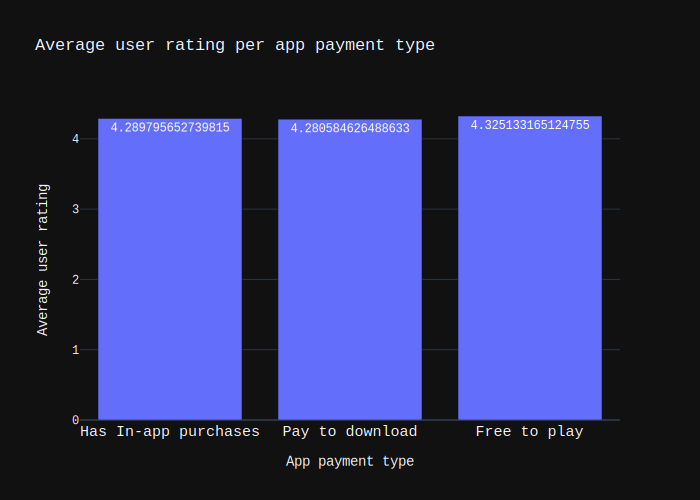

In [46]:
fig = go.Figure(data=[
    go.Bar(name='Price',x =['Has In-app purchases','Pay to download','Free to play'] ,y = (b[1],d[1],f[0]), text=(b[1],d[1],f[0]))])
fig.update_layout(hoverlabel=dict(font=dict(family='sans-serif', size=25)),barmode='relative', template='plotly_dark', title_text='Average user rating per app payment type', font_family="Courier New")
fig.update_yaxes(title_text='Average user rating')
fig.update_xaxes(title_text='App payment type',tickfont_size=15)
fig.show(renderer="svg")   

**Conclusion:** Whether an app has in-app purchases, costs money to download or is totally free to play, there seems to be no impact on the games rating. However, free to play games has a very slight advantage over the other 2.


### What genre and subgenres are the most popular? 

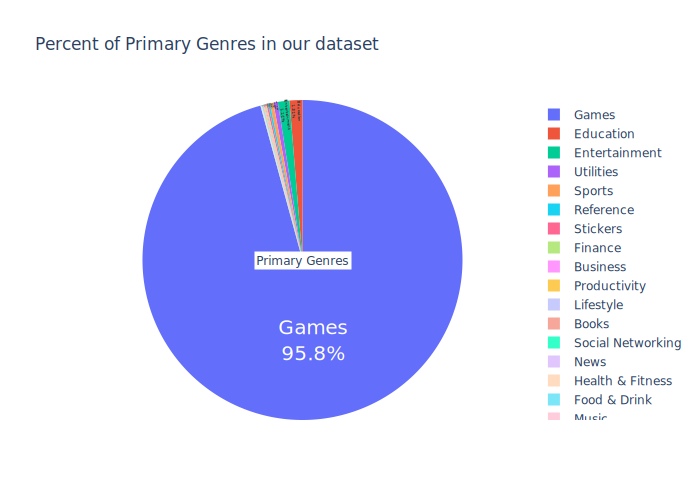

In [47]:
genre_count = games['Primary Genre'].value_counts().sort_values(ascending=False)
fig = go.Figure(data=[go.Pie(labels=genre_count.index, values=genre_count.values)])
fig.update_layout(hoverlabel=dict(font=dict(family='sans-serif', size=25)),
    title_text="Percent of Primary Genres in our dataset", annotations=[dict(text='Primary Genres',bgcolor='white', font_size=12, showarrow=False)])
fig.update_traces(hoverinfo='percent', textinfo='label+percent', textfont_size=20,textposition='inside')
fig.show(renderer="svg")

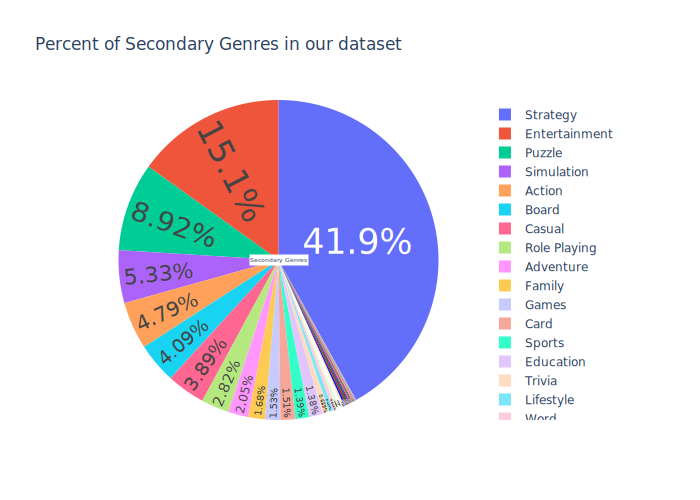

In [48]:
genre_count = games['Secondary Genre'].value_counts().sort_values(ascending=False)
fig = go.Figure(data=[go.Pie(labels=genre_count.index, values=genre_count.values)])
fig.update_layout(hoverlabel=dict(font=dict(family='sans-serif', size=25)),
    title_text="Percent of Secondary Genres in our dataset", annotations=[dict(text='Secondary Genres', bgcolor='white', font_size=6, showarrow=False)])
fig.update_traces(hoverinfo='percent', textinfo='percent', textfont_size=35,textposition='inside')
fig.show(renderer="svg")

Conclusion: Games overtake every other Genre by far. While Strategy games are the most popular form of game, with entertainment coming at second.

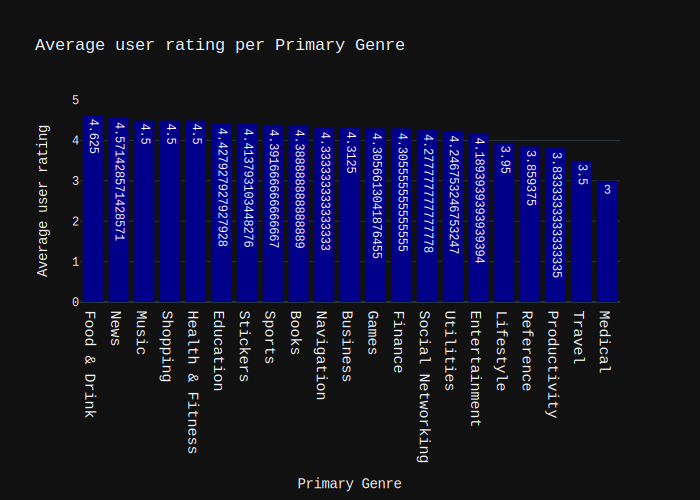

In [49]:
primary_avg = games.groupby('Primary Genre')[['Average User Rating']].mean().sort_values(by = ['Average User Rating'], ascending = False)

fig = go.Figure(data=[
    go.Bar(name='Primary', x =primary_avg.index  ,y = primary_avg['Average User Rating'] , text= primary_avg['Average User Rating'], marker_color='darkblue')])
fig.update_layout(hoverlabel=dict(font=dict(family='sans-serif', size=25)),barmode='relative', template='plotly_dark', title_text='Average user rating per Primary Genre', font_family="Courier New")
fig.update_yaxes(title_text='Average user rating', range=[0,5])
fig.update_xaxes(title_text='Primary Genre',tickfont_size=15)
fig.show(renderer="svg")   

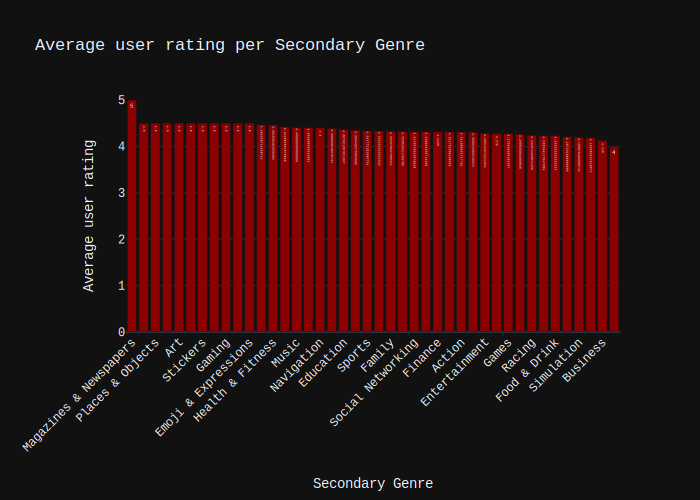

In [50]:
secondary_avg = games.groupby('Secondary Genre')[['Average User Rating']].mean().sort_values(by = 'Average User Rating', ascending = False)


fig = go.Figure(data=
    go.Bar(name='secondary', x =secondary_avg.index  ,y = secondary_avg['Average User Rating'], text= secondary_avg['Average User Rating'], marker_color='darkred'))
fig.update_layout(hoverlabel=dict(font=dict(family='sans-serif', size=25)),barmode='relative', template='plotly_dark', title_text='Average user rating per Secondary Genre', font_family="Courier New", xaxis_tickangle=-45)
fig.update_yaxes(title_text='Average user rating', range=[0,5])
fig.update_xaxes(title_text='Secondary Genre',tickfont_size=12)
fig.show(renderer="svg")  

Conclusion: The graphs for both Genre categorys show the top rated genres. Food&Drink, News, and Music lead the primary genres, while magazines&newspapers, Medical and Places&Objects lead secondary genres.

### Which developers rack the highest/lowest average ratings?

In [51]:
more_than_500_reviews = games.loc[(games['User Rating Count'] >= 500)]
top_dev_ratings = more_than_500_reviews.groupby('Developer')[['Average User Rating']].mean().sort_values(by = 'Average User Rating', ascending = False).head(15)
low_dev_ratings = more_than_500_reviews.groupby('Developer')[['Average User Rating']].mean().sort_values(by = 'Average User Rating', ascending = True).head(15)

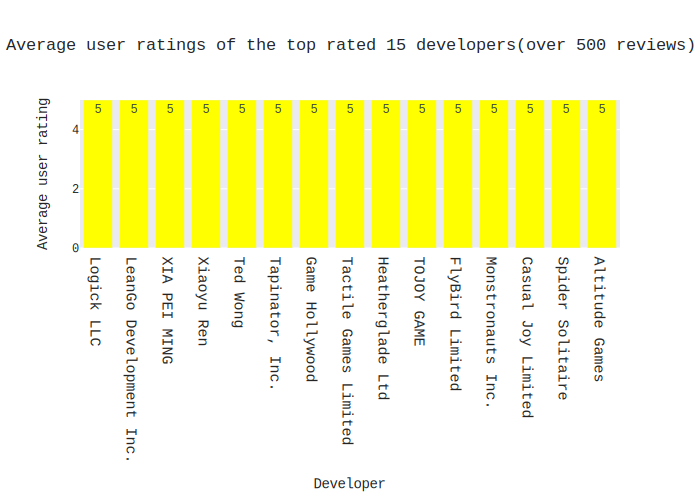

In [52]:
fig = go.Figure(data=[
    go.Bar(name='Primary', x =top_dev_ratings.index  ,y = top_dev_ratings['Average User Rating'], text= top_dev_ratings['Average User Rating'], marker_color='yellow')])
fig.update_layout(hoverlabel=dict(font=dict(family='sans-serif', size=20)),barmode='relative', template='seaborn', title_text='Average user ratings of the top rated 15 developers(over 500 reviews)', font_family="Courier New")
fig.update_yaxes(title_text='Average user rating', range=[0,5])
fig.update_xaxes(title_text='Developer',tickfont_size=15)
fig.show(renderer="svg")  

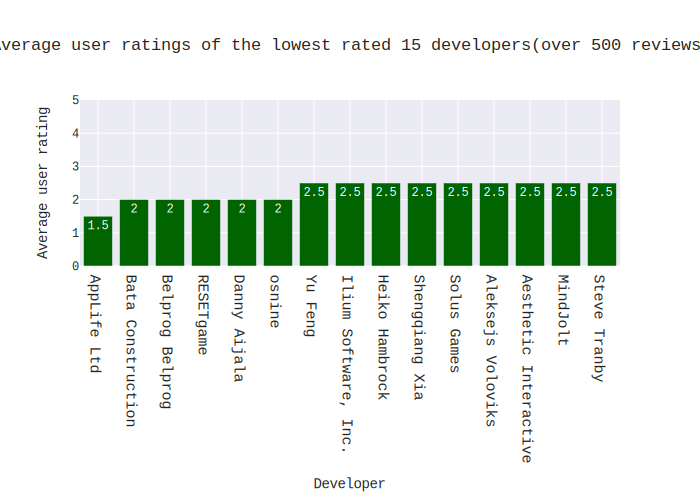

In [53]:
fig = go.Figure(data=[
    go.Bar(name='Primary', x =low_dev_ratings.index  ,y =low_dev_ratings['Average User Rating'], text=low_dev_ratings['Average User Rating'], marker_color='darkgreen')])
fig.update_layout(hoverlabel=dict(font=dict(family='sans-serif', size=20)),barmode='relative', template='seaborn', title_text='Average user ratings of the lowest rated 15 developers(over 500 reviews)', font_family="Courier New")
fig.update_yaxes(title_text='Average user rating', range=[0,5])
fig.update_xaxes(title_text='Developer',tickfont_size=15)
fig.show(renderer="svg")  

### What are the most common words used in app descriptions?

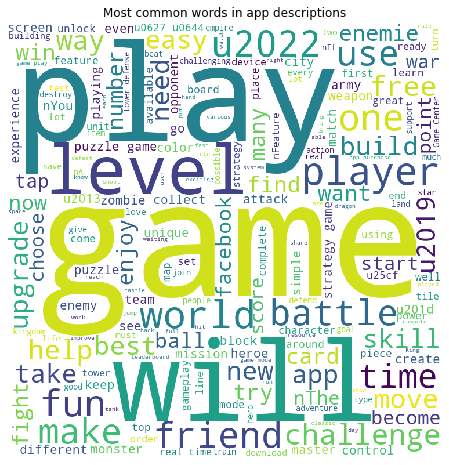

In [54]:
f,ax= plt.subplots(figsize=(15,8))
wordcloud = WordCloud(background_color='white',width=750, height=750).generate(' '.join(descriptions))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most common words in app descriptions')
plt.show()

###  Change in Price, Size, and User rating count throughout the years.

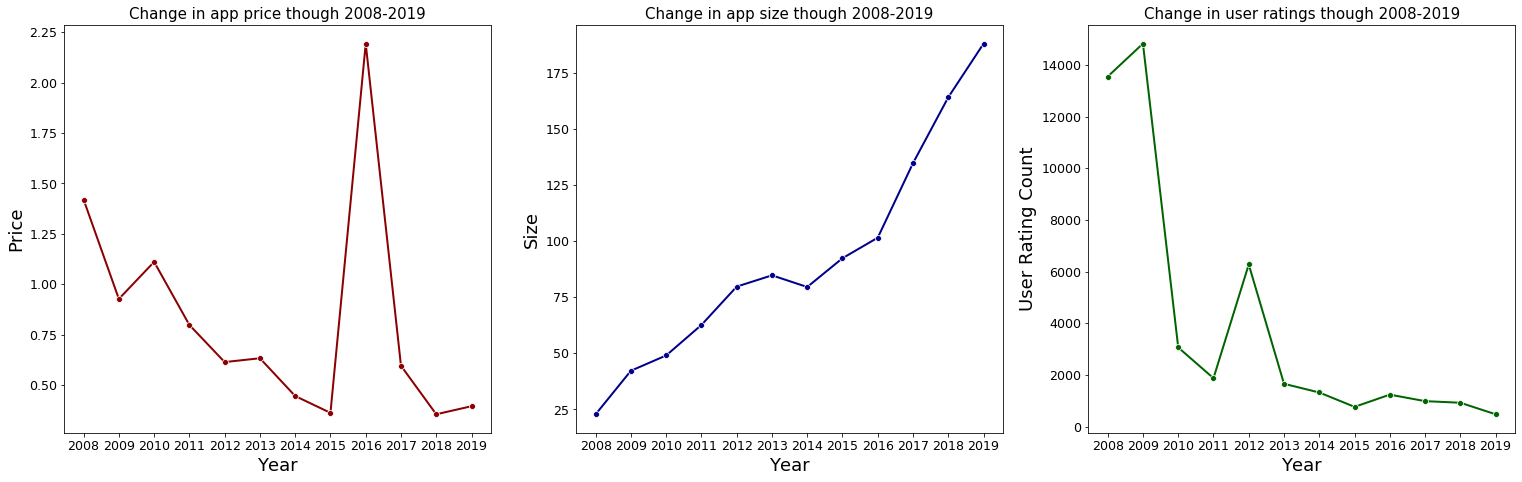

In [55]:
ord_price = games.groupby('Original Release Date')[['Price']].mean()
ord_size = games.groupby('Original Release Date')[['Size']].mean()
ord_urc = games.groupby('Original Release Date')[['User Rating Count']].mean()

fig, ax = plt.subplots(1, 3, figsize=(26, 7.5))

sns.lineplot(x='Original Release Date', y='Price', data=ord_price, color = 'darkred', ax=ax[0], marker='o', linewidth = 2)
ax[0].set_title('Change in app price though 2008-2019', fontsize = 15)
ax[0].tick_params(labelsize=12.6)
ax[0].set_xlabel('Year',fontsize = 18)
ax[0].set_ylabel('Price',fontsize = 18)

sns.lineplot(x='Original Release Date', y='Size', data=ord_size, color = 'darkblue', ax=ax[1], marker='o', linewidth = 2)
ax[1].set_title('Change in app size though 2008-2019', fontsize = 15)
ax[1].tick_params(labelsize=12.6)
ax[1].set_xlabel('Year',fontsize = 18)
ax[1].set_ylabel('Size',fontsize = 18)

sns.lineplot(x='Original Release Date', y='User Rating Count', data=ord_urc, color = 'darkgreen', ax=ax[2], marker='o', linewidth = 2)
ax[2].set_title('Change in user ratings though 2008-2019', fontsize = 15)
ax[2].tick_params(labelsize=12.6)
ax[2].set_xlabel('Year',fontsize = 18)
ax[2].set_ylabel('User Rating Count',fontsize = 18)

plt.show()

### Top 5 apps with the perfect rating and highest rating count.

In [56]:
t5a = games.loc[(games['User Rating Count'] >= 100000)]
t5a2 = t5a.loc[(t5a['Average User Rating'] == 5)]
t5a3 = t5a2.groupby(['Name']).agg({"Average User Rating":"sum", "User Rating Count":"sum"}).sort_values(by = 'User Rating Count', ascending = False).head(5)
t5a3

,Average User Rating,User Rating Count
Name,,
"Cash, Inc. Fame & Fortune Game",5.0,374772.0
"Egg, Inc.",5.0,174591.0
AFK Arena,5.0,156766.0
South Park: Phone Destroyer\u2122,5.0,156044.0
From Zero to Hero: Cityman,5.0,146729.0


## 7. Model preparation

- Encode data
- Split the data
- Scale data

In [57]:
df = games.copy()
df['Average User Rating'] = df['Average User Rating'].astype(int)

*Encode the data*

In [58]:
label_encoded=df[['User Rating Count', 'Price',  'Size', 'Developer', 'Languages','Primary Genre',
                     'Secondary Genre', 'Original Release Date', 'Current Version Release Date']]
                       
onehot_coded = df[['In-app Purchases', 'FreeToPlay', 'Age Rating']]

#onehotencoded
enc = OneHotEncoder(handle_unknown='ignore')
df_oh = pd.DataFrame(enc.fit_transform(onehot_coded).toarray(), columns = enc.get_feature_names()) #df_oh.columns


#labelencoder
df_le = label_encoded.apply(LabelEncoder().fit_transform)
dataframe = df_le.join(df_oh)
dataframe.head()

,User Rating Count,Price,Size,Developer,Languages,Primary Genre,Secondary Genre,Original Release Date,Current Version Release Date,x0_0,x0_1,x1_0,x1_1,x2_4,x2_9,x2_12,x2_17
0,1192,3,1210,4801,16,6,37,0,9,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,276,2,891,3992,0,6,37,0,10,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1411,0,20,905,0,6,4,0,9,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1768,0,1723,4801,16,6,37,0,9,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,23,3,2785,6067,14,6,37,0,10,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


*Split data*

In [59]:
Y = pd.DataFrame(df['Average User Rating'])
X = dataframe

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1) 

*Scale data*

In [61]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

##### Look at the individual variables

In [62]:
xstats = dataframe.values
ystats = games.loc[:,'Average User Rating'].values

x1 = sm.add_constant(xstats)
results = sm.OLS(ystats,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     140.4
Date:                Thu, 04 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:04:10   Log-Likelihood:                -12923.
No. Observations:               17007   AIC:                         2.588e+04
Df Residuals:                   16992   BIC:                         2.599e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6496      0.012    132.363      0.000       1.625       1.674
x1             0.0002    1.4e-05     14.089      0.000       0.000       0.000
x2             0.0036      0.003      1.356      0.175      -0.002       0.009
x3         -1.686e-05   1.54e-06    -10.976      0.000   -1.99e-05   -1.39e-05
x4          7.427e-07   1.59e-06      0.466      0.641   -2.38e-06    3.87e-06
x5            -0.0012      0.001     -1.834      0.067      -0.003    8.55e-05
x6            -0.0077      0.003     -2.848      0.004      -0.013      -0.002
x7            -0.0003      0.000     -1.165      0.244      -0.001       0.000
x8             0.0805      0.002     33.369      0.000       0.076       0.085
x9             0.0042      0.003      1.429      0.153      -0.002       0.010
x10            0.8360      0.010     86.850      0.000       0.817       0.855
x11            0.8136      0.010     82.519      0.000       0.794       0.833
x12            0.8394      0.010     85.578      0.000       0.820       0.859
x13            0.8102      0.010     82.036      0.000       0.791       0.830
x14            0.4754      0.008     63.006      0.000       0.461       0.490
x15            0.4113      0.010     40.743      0.000       0.392       0.431
x16            0.3902      0.011     35.645      0.000       0.369       0.412
x17            0.3727      0.017     22.499      0.000       0.340       0.405
==============================================================================
Omnibus:                     8563.227   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57341.447
Skew:                          -2.369   Prob(JB):                         0.00
Kurtosis:                      10.646   Cond. No.                     2.40e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.44e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [63]:
rfc_model = RandomForestClassifier(random_state=0).fit(X_train, Y_train)
perm = PermutationImportance(rfc_model, random_state=1).fit(X_test, Y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist() )# = xperm_test.columns.tolist()

Weight,Feature
0.0383 ± 0.0062,User Rating Count
0.0119 ± 0.0052,Original Release Date
0.0036 ± 0.0014,Current Version Release Date
0.0031 ± 0.0040,Developer
0.0029 ± 0.0025,Size
0.0011 ± 0.0009,Price
0.0011 ± 0.0040,x2_4
0.0006 ± 0.0004,x2_17
0.0004 ± 0.0006,x2_12
0.0001 ± 0.0020,Languages


Most important variable: User rating count.

## 8. Model validation

Accuracy score: Overall model score on training sets.

Precision score: Computes the precision of the model.

F1 score: Weighted average of precision and recall values.

##### X_train, Y_train, X_val, Y_val

In [64]:
def validation_predictor(ml): 
    model = ml.fit(X_train,Y_train)
    print('Model: ',model)
    print('\n')
    global y_pred_val
    y_pred_val = model.predict(X_val)
    cm = confusion_matrix(Y_val, y_pred_val)
    
    print('Accuracy score on train sets: {}'.format(model.score(X_train,Y_train)))
    print('Precision score: {}'.format(precision_score(Y_val, y_pred_val, average='micro')))
    print('F1 score: {}'.format(f1_score(Y_val, y_pred_val, average='macro')))

In [65]:
validation_predictor(KNeighborsClassifier(n_neighbors = 6, weights = 'uniform', n_jobs=-1, p = 2))

Model:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                     weights='uniform')


Accuracy score on train sets: 0.8411251592668822
Precision score: 0.8130511463844797
F1 score: 0.22231162594177994


In [66]:
validation_predictor(DecisionTreeClassifier(ccp_alpha=0.0001, criterion = 'gini', max_depth=25, random_state = 10))

Model:  DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='gini',
                       max_depth=25, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')


Accuracy score on train sets: 0.9748113300009801
Precision score: 0.7748383303938859
F1 score: 0.30019355856584634


In [67]:
validation_predictor(CatBoostClassifier(iterations=1550,depth=5, learning_rate=.25, eval_metric='AUC', verbose = False))

Model:  <catboost.core.CatBoostClassifier object at 0x00000238055F2D48>


Accuracy score on train sets: 0.9928452415956092
Precision score: 0.8151087595532039
F1 score: 0.30782676655333485


In [68]:
validation_predictor(RandomForestClassifier(ccp_alpha=0.001,n_estimators=50, max_depth = 25, criterion = 'entropy',
                                            oob_score =  True, random_state = 4))

Model:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.001, class_weight=None,
                       criterion='entropy', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=True, random_state=4, verbose=0,
                       warm_start=False)


Accuracy score on train sets: 0.8471037930020582
Precision score: 0.8236331569664903
F1 score: 0.22316251825847763


In [69]:
validation_predictor(xgb.XGBClassifier(eval_metric='mlogloss',learning_rate=0.08,
                                       max_depth=5, n_estimators=1000, random_state =7, nthread = -1))

Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.08, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              nthread=-1, num_parallel_tree=1, objective='multi:softprob',
              random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)


Accuracy score on train sets: 0.994413407821229
Precision score: 0.8203997648442093
F1 score: 0.32787914064332124


In [70]:
validation_predictor(lgb.LGBMClassifier(objective='multiclass',num_leaves=5, max_depth = -1,
                              learning_rate=0.15, n_estimators=2300, max_bin = 55))

Model:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.15, max_bin=55,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=2300, n_jobs=-1, num_leaves=5,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


Accuracy score on train sets: 0.9946094285994316
Precision score: 0.8095238095238095
F1 score: 0.31828004868505716


## 9. Final model build

In [71]:
def predictor(ml): 
    model = ml.fit(X_train,Y_train)
    global y_pred
    y_pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, y_pred)
    
    print('Accuracy score on train sets: {}'.format(model.score(X_train,Y_train)))
    print('Precision score: {}'.format(precision_score(Y_test, y_pred, average='micro')))

### K-Neighbors

In [72]:
predictor(KNeighborsClassifier(n_neighbors = 3, weights = 'uniform', n_jobs=-1, p = 5))

KNC = y_pred

Accuracy score on train sets: 0.8571008526903852
Precision score: 0.7771898883009994


### Decision Tree

In [73]:
predictor(DecisionTreeClassifier(ccp_alpha=0.0001, criterion = 'gini', max_depth=25, random_state = 10))

Accuracy score on train sets: 0.9748113300009801
Precision score: 0.7921810699588477


### Catboost

In [74]:
predictor(CatBoostClassifier(iterations=1550,depth=5, learning_rate=.25, eval_metric='AUC', verbose = False))

Accuracy score on train sets: 0.9928452415956092
Precision score: 0.823045267489712


### Random forest

In [75]:
predictor(RandomForestClassifier(ccp_alpha=0.001,n_estimators=50, max_depth = 25, criterion = 'entropy',
                                 oob_score =  True, random_state = 4))

Accuracy score on train sets: 0.8471037930020582
Precision score: 0.8242210464432687


### XGBoost

In [76]:
predictor(xgb.XGBClassifier(eval_metric='mlogloss',learning_rate=0.08,
                                       max_depth=5, n_estimators=1000, random_state =7, nthread = -1))

Accuracy score on train sets: 0.994413407821229
Precision score: 0.8245149911816578


### LGBM

In [77]:
predictor(lgb.LGBMClassifier(objective='multiclass',num_leaves=5, max_depth = -1,
                              learning_rate=0.15, n_estimators=2300, max_bin = 55))

Accuracy score on train sets: 0.9946094285994316
Precision score: 0.8171663727219283
